## using treesignal on drosophila root HOGs from OMA
- the species tree was found by guenomu's ML using some 500 rootHOGs 
- (a proper guenomu run on ~200 HOGs gave a sptree consistent with publications, but I overwrote it. I didn't check the consistency of this tree.)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sys, subprocess, time, dendropy, os, copy, glob, ete3
from ete3 import TreeStyle
import numpy as np
from sklearn import manifold, metrics, cluster, neighbors, decomposition, preprocessing
import treesignal

### Loading reference trees (sptrees)
After estimating maximum likelihood sptree with guenomu, we add 50% of noise, generating 976 noisy trees. **In case you want fewer reference trees**, the 11 first trees have > 1% each, and the 100 first trees have > 0.3% each (decaying to 0.02% or less after that), since trees in noise.tre are ordered by frequency. 

In [2]:
data_dir = "/home/leo/Academic/Projects/205.oma/drosophila/"
f_dir = data_dir + "aligntree/*.treefile"
spfile = data_dir + "nexus/noise.tre" # guenomu output with addNoise
sptrees = dendropy.TreeList.get_from_path (spfile, "nexus", preserve_underscores=True)
sptrees = sptrees[:50] # if you want to work if a fraction only

The code below *is not necessary* since *noise.tre* already has noise, and therefore the *script false* (works only on linux). But if you want to explicitly generate SPR neighbours, this is one way to do it. 

In [3]:
%%script false  ## CODE BELOW IS NOT RUN
spstring = ""
for tree in sptree[:15]:
    spstring += tre.as_string("newick",suppress_edge_lengths=True).rstrip().replace("'","")   
sptrees = treesignal.lowlevel_randomise_trees_with_spr_string(spstring, n_copies=2, n_spr=3)
sptrees = dendropy.TreeList.get(data=sptrees, schema="newick")

### Calculate feature matrix rows using reference sptrees as samples 
* function yield_from_files allow several files to be read at once, and trees being read one by one
* the calculated distances are scaled using 'p-values' and also empirical MinMax (set using "replicates" parameter)
* version 2017.11.10 also uses 'observed' reference sptrees in p-value calculation. That is, if we have 100 sptrees and 200 random replicates, then p-value will be fraction of 300 trees.

In [3]:
ts = treesignal.TreeSignal(sp_trees = sptrees, replicates=500)

feat_mat = []
genesize = []
t_index  = []
t_sample = []

for idx, tre in enumerate(sptrees):
    spectrum = ts(tre)
    if spectrum.max() > -1.: # if genetree is too small etc. there is no spectrum
        feat_mat.append(spectrum)
        genesize.append(len(tre.leaf_nodes()))
        t_index.append(idx)
        t_sample.append(tre)
geneidx = int(1.5 * len(sptrees)) # this will be single index for all gene trees 

### Read gene trees and update feature matrix rows 
* function yield_from_files allow several files to be read at once, and trees being read one by one

In [4]:
for file in glob.glob(f_dir):
    tyield = dendropy.Tree.yield_from_files(files=[file], schema="newick", preserve_underscores=True)
    for idx, tre in enumerate (tyield): # iterate over trees as it reads (not everything in memory at once)
        if idx > 0: # read only first trees
            break
        else:
            #print (tre.as_string("newick",suppress_edge_lengths=True).replace("'",""))
            spectrum = ts(tre)
            if spectrum.max() > -1.: # if genetree is too small etc. there is no spectrum
                feat_mat.append(spectrum)
                genesize.append(len(tre.leaf_nodes()))
                t_index.append(geneidx)
                t_sample.append(tre)
    
feat_mat = np.array(feat_mat[::-1])
genesize = np.array(genesize[::-1])
t_index = np.array(t_index[::-1])
t_sample = np.array(t_sample[::-1])
print ("dimensions: ", feat_mat.shape) 

dimensions:  (1209, 600)


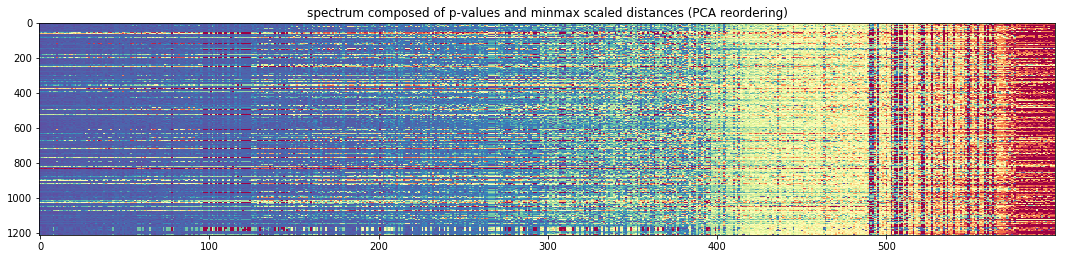

In [5]:
## order of the FEATURES (distances) using first PC 
feat_order = np.argsort(decomposition.PCA(n_components=2).fit_transform(feat_mat.T)[:,0])
fig, axes = plt.subplots(1) ; fig.set_size_inches(15,3)
fig.subplots_adjust(top=.99, bottom=.01, left=.03, right=.97, wspace=.1, hspace=.1)
axes.imshow(feat_mat[:,feat_order],aspect='auto', cmap="Spectral_r", interpolation="nearest")
axes.set_title("spectrum composed of p-values and minmax scaled distances (PCA reordering)")

In [6]:
#fmatrix = feat_mat[:,int(feat_mat.shape[1]/2):]
fmatrix = feat_mat/feat_mat.mean(0)
transf_I = manifold.Isomap(n_neighbors=10, n_components=2).fit_transform(fmatrix)
transf_M = manifold.MDS(n_components=2).fit_transform(fmatrix)
transf_S = manifold.SpectralEmbedding(n_components=2).fit_transform(fmatrix)

In [7]:
#play a bit more with t-SNE perplexity
transf_T = manifold.TSNE(n_components=2, perplexity=50, n_iter=1000).fit_transform(fmatrix)

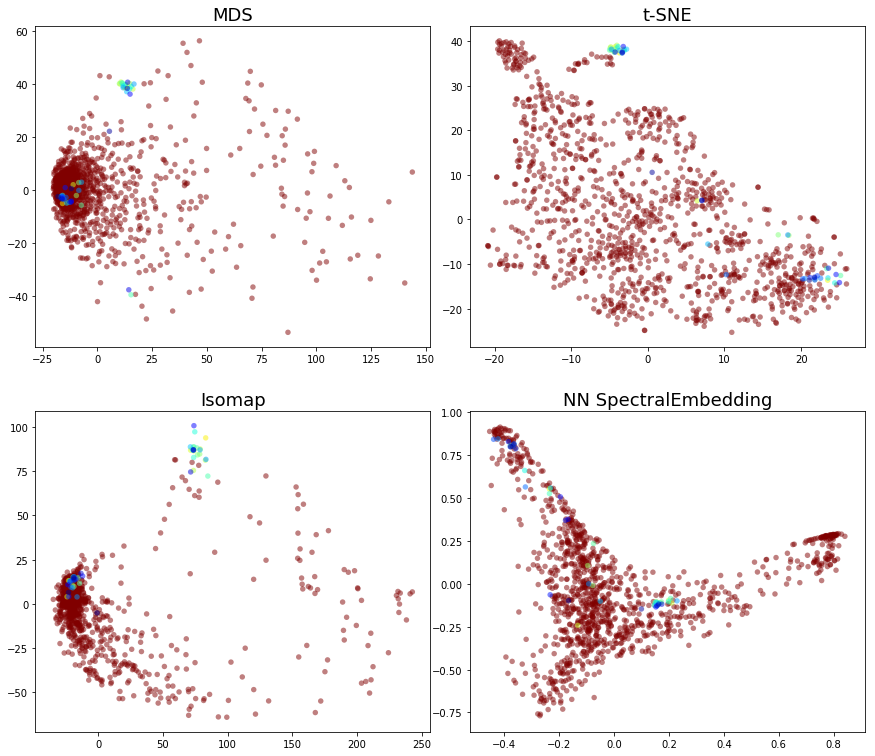

In [8]:
#  %%script false # tell jupyter NOT TO RUN cell (on linux only)
fig, axes = plt.subplots(2,2) ; fig.set_size_inches(12, 10)
fig.subplots_adjust(top=.99, bottom=.01, left=.02, right=.98, wspace=.1, hspace=.2)
 
axes[0,0].scatter(transf_M[:,0], transf_M[:,1], c=t_index, edgecolor="none", cmap="jet", alpha=.5, s=30)
axes[0,0].set_title("MDS",  fontsize=18)
axes[0,1].scatter(transf_T[:,0], transf_T[:,1], c=t_index, edgecolor="none", cmap="jet", alpha=.5, s=30)
axes[0,1].set_title("t-SNE",  fontsize=18)
axes[1,0].scatter(transf_I[:,0], transf_I[:,1], c=t_index, edgecolor="none", cmap="jet", alpha=.5, s=30)
axes[1,0].set_title("Isomap",  fontsize=18)
axes[1,1].scatter(transf_S[:,0], transf_S[:,1], c=t_index, edgecolor="none", cmap="jet", alpha=.5, s=30)
axes[1,1].set_title("NN SpectralEmbedding",  fontsize=18)

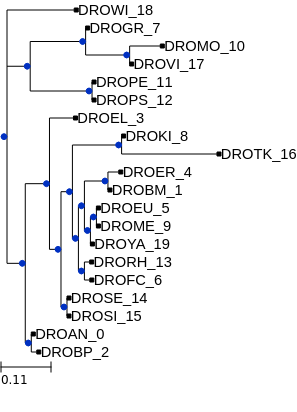

In [13]:
# could also apply PCA before: decomposition.PCA(n_components=2).fit_transform(transf_M)
t_o = np.argsort(transf_M[:,0]); # first positions will be the most positive with [::-1]
ete3.PhyloTree(t_sample[t_o[0]].as_string(schema="newick").rstrip().replace("'","")).render("%%inline")

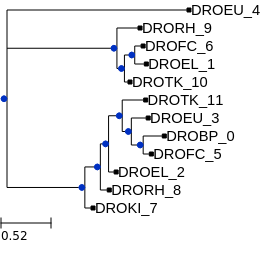

In [14]:
ete3.PhyloTree(t_sample[t_o[-1]].as_string(schema="newick").rstrip().replace("'","")).render("%%inline")

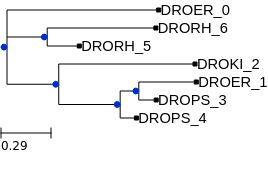

In [15]:
t_o = np.argsort(transf_M[:,1]); 
ete3.PhyloTree(t_sample[t_o[0]].as_string(schema="newick").rstrip().replace("'","")).render("%%inline")

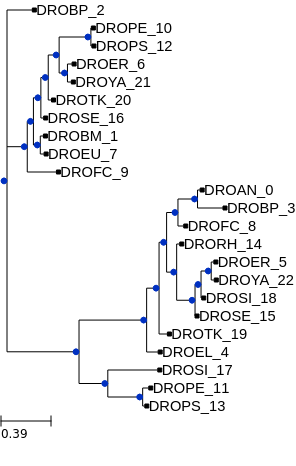

In [16]:
ete3.PhyloTree(t_sample[t_o[-1]].as_string(schema="newick").rstrip().replace("'","")).render("%%inline")